## 1. Import Libraries

In [1]:
import re
import nltk
import requests
import warnings
import numpy as np
import contractions
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from joblib import Parallel, delayed
from collections import defaultdict
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

## 2. Import Data

In [2]:
## columns present in the dataset
columns = ['text', 'location', 'tone', 'date', 'ID', 'URL', 'MBFC_factuality_label', 'URL.1', 
           'MBFC_factuality_label.1', 'URL_to_MBFC_page', 'source_name', 'MBFC_notes_about_source', 
           'MBFC_bias_label', 'source_URL', 'propaganda_label']

In [3]:
## load data
df_train = pd.read_csv('proppy_1.0.train.tsv', names=columns, sep='\t')
print(f"train shape : {df_train.shape}")

train shape : (35986, 15)


In [4]:
df_valid = pd.read_csv('proppy_1.0.dev.tsv', names=columns, sep='\t')
print(f"validrain shape : {df_valid.shape}")

validrain shape : (5125, 15)


In [5]:
df_test = pd.read_csv('proppy_1.0.test.tsv', names=columns, sep='\t')
print(f"validrain shape : {df_valid.shape}")

validrain shape : (5125, 15)


In [6]:
df_train.sample(2)

,text,location,tone,date,ID,URL,MBFC_factuality_label,URL.1,MBFC_factuality_label.1,URL_to_MBFC_page,source_name,MBFC_notes_about_source,MBFC_bias_label,source_URL,propaganda_label
17022,Students at Navajo Heights Elementary School w...,"Oak Park, Illinois, United States",-1.901141,2018-02-05,728389829,http://www.chicagotribune.com/suburbs/daily-so...,Howard Ludwig,Palos Heights elementary school closes after fire,HIGH,http://mediabiasfactcheck.com/chicago-tribune/,Chicago Tribune,NaN,NIL,chicagotribune.com,-1
35274,"On Tuesday, the Federal Bureau of Investigatio...",Denmark,-3.555556,2017-10-26,701130166,https://freedomoutpost.com/fbi-dumps-documents...,The Common Constitutionalist,FBI Dumps Documents On Sandy Hook - Guess Who ...,"Extreme Right, Propaganda, Conspiracy",http://mediabiasfactcheck.com/freedom-outpost/,Freedom Outpost,Notes (D. Van Zandt): Freedom Outpost is an ex...,NIL,freedomoutpost.com,1


*Both train and test dataset has 15 columns/features out of which we need only two features for model building, text and propaganda label.*

## 3. Data Cleaning

### 3.1 Null Values

In [7]:
df_train.isnull().sum()

text                          0
location                      0
tone                          0
date                          0
ID                            0
URL                           0
MBFC_factuality_label      9084
URL.1                         0
MBFC_factuality_label.1       0
URL_to_MBFC_page              0
source_name                   0
MBFC_notes_about_source    6007
MBFC_bias_label               0
source_URL                    0
propaganda_label              0
dtype: int64

In [8]:
df_valid.isnull().sum()

text                          0
location                      0
tone                          0
date                          0
ID                            0
URL                           0
MBFC_factuality_label      1674
URL.1                         0
MBFC_factuality_label.1       0
URL_to_MBFC_page              0
source_name                   0
MBFC_notes_about_source     612
MBFC_bias_label               0
source_URL                    0
propaganda_label              0
dtype: int64

In [9]:
df_test.isnull().sum()

text                          0
location                      0
tone                          0
date                          0
ID                            0
URL                           0
MBFC_factuality_label      3525
URL.1                         0
MBFC_factuality_label.1       0
URL_to_MBFC_page              0
source_name                   0
MBFC_notes_about_source    1198
MBFC_bias_label               0
source_URL                    0
propaganda_label              0
dtype: int64

### 3.2 Duplicate Rows

In [10]:
df_train[['text', 'propaganda_label']].duplicated().sum()

0

In [11]:
df_valid[['text', 'propaganda_label']].duplicated().sum()

0

In [12]:
df_test[['text', 'propaganda_label']].duplicated().sum()

0

*There is no null values or duplicate rows present in the training and validation dataset.*

### 3.3 Removing Unwanted Columns

In [13]:
df_train = df_train[['text', 'propaganda_label']]
print(f"new train shape : {df_train.shape}")

df_valid = df_valid[['text', 'propaganda_label']]
print(f"new validation shape : {df_valid.shape}")

df_test= df_test[['text', 'propaganda_label']]
print(f"new test shape : {df_valid.shape}")

new train shape : (35986, 2)
new validation shape : (5125, 2)
new test shape : (5125, 2)


*Removing all other features and keeping only text and label for further analysis.*

## 4. Output Analysis

### Target Variable

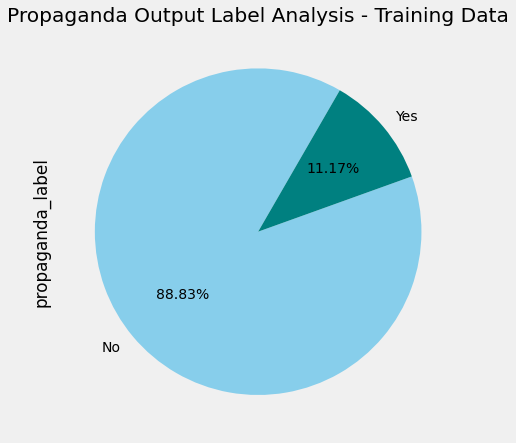

In [14]:
data = df_train['propaganda_label'].map({-1 : 'No', 1 : 'Yes'}).value_counts()
data.plot(kind = 'pie',
          autopct = '%.2f%%',
          colors = ['skyblue', 'teal'],
          figsize=(7,7),
          startangle = 60,
          title = "Propaganda Output Label Analysis - Training Data")
plt.show()

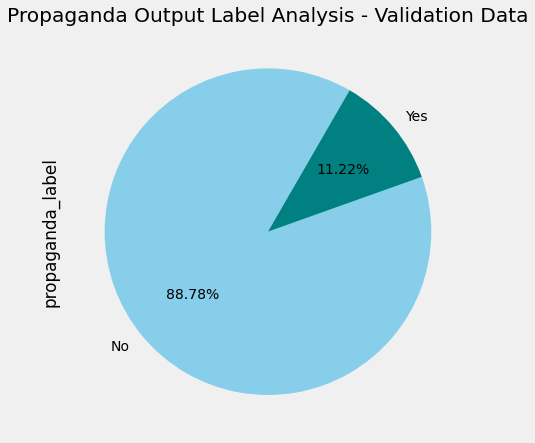

In [15]:
data = df_valid['propaganda_label'].map({-1 : 'No', 1 : 'Yes'}).value_counts()
data.plot(kind = 'pie',
          autopct = '%.2f%%',
          colors = ['skyblue', 'teal'],
          figsize=(7,7),
          startangle = 60,
          title = "Propaganda Output Label Analysis - Validation Data")
plt.show()

*The output class is highly imbalance with 11.22% of propaganda news present in the dataset. For both training and validation data, the class output ratio is same.*

## 5. Text Pre-processing

In [16]:
def text_preprocessing(text, stopword_list, stemming):
    """
    This function performs text preprocessing on a given review.
    Input:
        text (string)         : a string of sentences
        stopwords(list)       : a list of stopwords
        stemming(object)      : stemming object to apply on words
    Output:
        preprop_text (string) : a string of formated sentences
    """
    preprop_text = text.replace(r"won’t", "will not").replace(r"can’t", "can not")\
                       .replace(r"n’t", " not").replace(r"’re", " are")\
                       .replace("’s", " is").replace(r"'d", " would")\
                       .replace(r"’ll", " will").replace(r"’t", " not")\
                       .replace(r"’ve", " have").replace(r"’m", " am")
    preprop_text = re.sub(r'[^a-zA-Z ]+', ' ', preprop_text)
    preprop_text = preprop_text.lower()
    preprop_text = " ".join(word for word in preprop_text.split() if word not in stopword_list)
    preprop_text = " ".join(stemming.stem(val) for val in preprop_text.split())
    preprop_text_final = preprop_text.strip()
    return (preprop_text_final, preprop_text)

In [17]:
## the below code is taken from the given source
## We are using a manually uploaded text file of stopwords to remove from the text

## https://gist.github.com/sebleier/554280
stopword_path = "https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt"
stopwords = requests.get(stopword_path).content
stopword_list = list(set(stopwords.decode().splitlines()))

## applying porter stemming
ps = nltk.stem.PorterStemmer()

In [18]:
## applying preprocessing to all text
text_train = Parallel(n_jobs=-1)(delayed(text_preprocessing)
                                                   (text, stopword_list, ps)
                                                   for text in tqdm(df_train['text'].values))

text_valid = Parallel(n_jobs=-1)(delayed(text_preprocessing)
                                                   (text, stopword_list, ps)
                                                   for text in tqdm(df_valid['text'].values))

  0%|          | 0/35986 [00:00<?, ?it/s]

  0%|          | 0/5125 [00:00<?, ?it/s]

In [19]:
## mapping to the original dataset
df_train['text2'] = [text[0] for text in text_train]
df_train['text1'] = [text[1] for text in text_train]

df_valid['text2'] = [text[0] for text in text_valid]
df_valid['text1'] = [text[1] for text in text_valid]

In [20]:
## checking for orginal and preprocessed text
df_train['text'].values[0]

'Et tu, Rhody?  A recent editorial in the Providence Journal cataloged everything it could find wrong with Connecticut and ended with this suggestion: “Gov. Gina Raimondo should see if at least some of those jobs could come to Rhode Island. It is certainly less risky than the Nutmeg State.”  We beg your pardon.  The state with world-famous pension problems and persistent economic issues of its own is “less risky”?  The Journal itself reported just a few weeks ago on Rhode Island’s own significant economic problems, which in many ways reflect Connecticut’s.  Rhode Island enjoys a legacy of corruption that not even Connecticut can match. The ProJo won a Pulitzer Prize in 1994 for uncovering widespread corruption within its own court system.  What, exactly, is to be gained from moving to Rhode Island?  Like Connecticut, Rhode Island has an income tax and an estate tax with comparable rates. (Forbes magazine listed it as one of the states “Where Not To Die.” Connecticut made the list, too.

In [21]:
df_train['text2'].values[0]

'tu rhodi editori provid journal catalog wrong connecticut end suggest gov gina raimondo job rhode island riski nutmeg state beg pardon state famou pension problem persist econom issu riski journal report week ago rhode island econom problem way reflect connecticut rhode island enjoy legaci corrupt connecticut match projo pulitz prize uncov widespread corrupt court gain move rhode island connecticut rhode island incom tax estat tax compar rate forb magazin list state die connecticut list connecticut rhode island interdepend limit except interst economi creat electr boat groton border war bloodsh joke rhode island size honest connecticut lot depart interst competit fine connecticut suffer rhode island england matter connecticut lose resid troubl rate rhode island outmigr problem ocean state experienc net loss tax filer adjust gross incom destin state peopl fled rhode island massachusett florida wait connecticut connecticut resid move rhode island connecticut popul time big rhode island 